In [77]:
from os import listdir
from os.path import isfile, join

train_pos_path = 'movies/data/train/pos'
train_neg_path = 'movies/data/train/neg'
train_sup_path = 'movies/data/train/unsup'

def get_all_files(dir):
    return [('%s/%s' % (dir, f)) for f in listdir(dir) if isfile(join(dir, f))]    
    
all_pos_train_files = get_all_files(train_pos_path)
all_neg_train_files = get_all_files(train_pos_path)
all_unsup_train_files = get_all_files(train_pos_path)

In [79]:
def merge_all_into(target_file, origin_files):
    with open(target_file, 'w+', encoding="utf8") as outfile:
        for fname in origin_files:
            with open(fname,encoding="utf8") as infile:
                outfile.write(infile.read() + "\n")

merge_all_into('all_pos.txt', all_pos_train_files)
merge_all_into('all_neg.txt', all_neg_train_files)
merge_all_into('all_unsup.txt', all_unsup_train_files)

In [87]:
from sklearn.model_selection import train_test_split
import numpy as np

with open('all_pos.txt','r',encoding="utf8") as infile:
    pos_reviews = infile.readlines()
    
with open('all_neg.txt','r',encoding="utf8") as infile:
    neg_reviews = infile.readlines()
    
with open('all_sup.txt','r',encoding="utf8") as infile:
    unsup_reviews = infile.readlines()
    
#use 1 for positive sentiment, 0 for negative
y = np.concatenate((np.ones(len(pos_reviews)), np.zeros(len(neg_reviews))))
x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_reviews, neg_reviews)), y, test_size=0.2)
    

In [89]:
from bs4 import BeautifulSoup
import re

def cleanText(text): 
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = text.lower()
    text = text.replace('"', '')
    text = text.replace('...', '')
    text = text.replace('<br />', '')
    return text

x_train = [cleanText(text) for text in x_train]
x_test = [cleanText(text) for text in x_test]
unsup_reviews = [cleanText(text) for text in unsup_reviews]

In [90]:
import nltk
from nltk.corpus import stopwords

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [91]:
 from gensim.models.doc2vec import TaggedDocument

    
train_tagged = [TaggedDocument(words=tokenize_text(s), tags=['%s_%s'%('TRAIN',idx)]) for (idx, s) in enumerate(x_train)]
test_tagged = [TaggedDocument(words=tokenize_text(s), tags=['%s_%s'%('TEST',idx)]) for (idx, s) in enumerate(x_test)]
unsup_tagged = [TaggedDocument(words=tokenize_text(s), tags=['%s_%s'%('UNSUP',idx)]) for (idx, s) in enumerate(unsup_reviews)]


In [92]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [172]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.running_training_loss
        print(model.compute_loss)
        print('Loss after epoch {}: {}'.format(self.epoch, loss))
        self.epoch += 1

In [175]:
from tqdm import tqdm
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores, compute_loss=True, callbacks=[callback()])

model_dbow.compute_loss = True
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|██████████| 20000/20000 [00:00<00:00, 2448299.33it/s]


In [176]:
from sklearn import utils

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged)]), total_examples=len(train_tagged), epochs=10)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 20000/20000 [00:00<00:00, 2265782.89it/s]


False
Loss after epoch 0: 0.0
False
Loss after epoch 1: 0.0
False
Loss after epoch 2: 0.0
False
Loss after epoch 3: 0.0
False
Loss after epoch 4: 0.0
False
Loss after epoch 5: 0.0
False
Loss after epoch 6: 0.0
False
Loss after epoch 7: 0.0
False
Loss after epoch 8: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2785894.86it/s]

False
Loss after epoch 9: 0.0


False
Loss after epoch 10: 0.0
False
Loss after epoch 11: 0.0
False
Loss after epoch 12: 0.0
False
Loss after epoch 13: 0.0
False
Loss after epoch 14: 0.0
False
Loss after epoch 15: 0.0
False
Loss after epoch 16: 0.0
False
Loss after epoch 17: 0.0
False
Loss after epoch 18: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2525548.10it/s]

False
Loss after epoch 19: 0.0


False
Loss after epoch 20: 0.0
False
Loss after epoch 21: 0.0
False
Loss after epoch 22: 0.0
False
Loss after epoch 23: 0.0
False
Loss after epoch 24: 0.0
False
Loss after epoch 25: 0.0
False
Loss after epoch 26: 0.0
False
Loss after epoch 27: 0.0
False
Loss after epoch 28: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2438477.95it/s]

False
Loss after epoch 29: 0.0


False
Loss after epoch 30: 0.0
False
Loss after epoch 31: 0.0
False
Loss after epoch 32: 0.0
False
Loss after epoch 33: 0.0
False
Loss after epoch 34: 0.0
False
Loss after epoch 35: 0.0
False
Loss after epoch 36: 0.0
False
Loss after epoch 37: 0.0
False
Loss after epoch 38: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2742002.42it/s]

False
Loss after epoch 39: 0.0


False
Loss after epoch 40: 0.0
False
Loss after epoch 41: 0.0
False
Loss after epoch 42: 0.0
False
Loss after epoch 43: 0.0
False
Loss after epoch 44: 0.0
False
Loss after epoch 45: 0.0
False
Loss after epoch 46: 0.0
False
Loss after epoch 47: 0.0
False
Loss after epoch 48: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2680580.30it/s]

False
Loss after epoch 49: 0.0


False
Loss after epoch 50: 0.0
False
Loss after epoch 51: 0.0
False
Loss after epoch 52: 0.0
False
Loss after epoch 53: 0.0
False
Loss after epoch 54: 0.0
False
Loss after epoch 55: 0.0
False
Loss after epoch 56: 0.0
False
Loss after epoch 57: 0.0
False
Loss after epoch 58: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2696781.33it/s]

False
Loss after epoch 59: 0.0


False
Loss after epoch 60: 0.0
False
Loss after epoch 61: 0.0
False
Loss after epoch 62: 0.0
False
Loss after epoch 63: 0.0
False
Loss after epoch 64: 0.0
False
Loss after epoch 65: 0.0
False
Loss after epoch 66: 0.0
False
Loss after epoch 67: 0.0
False
Loss after epoch 68: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 3014773.76it/s]

False
Loss after epoch 69: 0.0


False
Loss after epoch 70: 0.0
False
Loss after epoch 71: 0.0
False
Loss after epoch 72: 0.0
False
Loss after epoch 73: 0.0
False
Loss after epoch 74: 0.0
False
Loss after epoch 75: 0.0
False
Loss after epoch 76: 0.0
False
Loss after epoch 77: 0.0
False
Loss after epoch 78: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2728091.32it/s]

False
Loss after epoch 79: 0.0


False
Loss after epoch 80: 0.0
False
Loss after epoch 81: 0.0
False
Loss after epoch 82: 0.0
False
Loss after epoch 83: 0.0
False
Loss after epoch 84: 0.0
False
Loss after epoch 85: 0.0
False
Loss after epoch 86: 0.0
False
Loss after epoch 87: 0.0
False
Loss after epoch 88: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2716694.09it/s]

False
Loss after epoch 89: 0.0


False
Loss after epoch 90: 0.0
False
Loss after epoch 91: 0.0
False
Loss after epoch 92: 0.0
False
Loss after epoch 93: 0.0
False
Loss after epoch 94: 0.0
False
Loss after epoch 95: 0.0
False
Loss after epoch 96: 0.0
False
Loss after epoch 97: 0.0
False
Loss after epoch 98: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2800216.31it/s]

False
Loss after epoch 99: 0.0


False
Loss after epoch 100: 0.0
False
Loss after epoch 101: 0.0
False
Loss after epoch 102: 0.0
False
Loss after epoch 103: 0.0
False
Loss after epoch 104: 0.0
False
Loss after epoch 105: 0.0
False
Loss after epoch 106: 0.0
False
Loss after epoch 107: 0.0
False
Loss after epoch 108: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2620129.94it/s]

False
Loss after epoch 109: 0.0


False
Loss after epoch 110: 0.0
False
Loss after epoch 111: 0.0
False
Loss after epoch 112: 0.0
False
Loss after epoch 113: 0.0
False
Loss after epoch 114: 0.0
False
Loss after epoch 115: 0.0
False
Loss after epoch 116: 0.0
False
Loss after epoch 117: 0.0
False
Loss after epoch 118: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2760863.61it/s]

False
Loss after epoch 119: 0.0


False
Loss after epoch 120: 0.0
False
Loss after epoch 121: 0.0
False
Loss after epoch 122: 0.0
False
Loss after epoch 123: 0.0
False
Loss after epoch 124: 0.0
False
Loss after epoch 125: 0.0
False
Loss after epoch 126: 0.0
False
Loss after epoch 127: 0.0
False
Loss after epoch 128: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2717750.28it/s]

False
Loss after epoch 129: 0.0


False
Loss after epoch 130: 0.0
False
Loss after epoch 131: 0.0
False
Loss after epoch 132: 0.0
False
Loss after epoch 133: 0.0
False
Loss after epoch 134: 0.0
False
Loss after epoch 135: 0.0
False
Loss after epoch 136: 0.0
False
Loss after epoch 137: 0.0
False
Loss after epoch 138: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2742002.42it/s]

False
Loss after epoch 139: 0.0


False
Loss after epoch 140: 0.0
False
Loss after epoch 141: 0.0
False
Loss after epoch 142: 0.0
False
Loss after epoch 143: 0.0
False
Loss after epoch 144: 0.0
False
Loss after epoch 145: 0.0
False
Loss after epoch 146: 0.0
False
Loss after epoch 147: 0.0
False
Loss after epoch 148: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2662036.05it/s]

False
Loss after epoch 149: 0.0


False
Loss after epoch 150: 0.0
False
Loss after epoch 151: 0.0
False
Loss after epoch 152: 0.0
False
Loss after epoch 153: 0.0
False
Loss after epoch 154: 0.0
False
Loss after epoch 155: 0.0
False
Loss after epoch 156: 0.0
False
Loss after epoch 157: 0.0
False
Loss after epoch 158: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2607668.25it/s]

False
Loss after epoch 159: 0.0


False
Loss after epoch 160: 0.0
False
Loss after epoch 161: 0.0
False
Loss after epoch 162: 0.0
False
Loss after epoch 163: 0.0
False
Loss after epoch 164: 0.0
False
Loss after epoch 165: 0.0
False
Loss after epoch 166: 0.0
False
Loss after epoch 167: 0.0
False
Loss after epoch 168: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2622259.46it/s]

False
Loss after epoch 169: 0.0


False
Loss after epoch 170: 0.0
False
Loss after epoch 171: 0.0
False
Loss after epoch 172: 0.0
False
Loss after epoch 173: 0.0
False
Loss after epoch 174: 0.0
False
Loss after epoch 175: 0.0
False
Loss after epoch 176: 0.0
False
Loss after epoch 177: 0.0
False
Loss after epoch 178: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2642996.94it/s]

False
Loss after epoch 179: 0.0


False
Loss after epoch 180: 0.0
False
Loss after epoch 181: 0.0
False
Loss after epoch 182: 0.0
False
Loss after epoch 183: 0.0
False
Loss after epoch 184: 0.0
False
Loss after epoch 185: 0.0
False
Loss after epoch 186: 0.0
False
Loss after epoch 187: 0.0
False
Loss after epoch 188: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2629163.17it/s]

False
Loss after epoch 189: 0.0


False
Loss after epoch 190: 0.0
False
Loss after epoch 191: 0.0
False
Loss after epoch 192: 0.0
False
Loss after epoch 193: 0.0
False
Loss after epoch 194: 0.0
False
Loss after epoch 195: 0.0
False
Loss after epoch 196: 0.0
False
Loss after epoch 197: 0.0
False
Loss after epoch 198: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2817995.16it/s]

False
Loss after epoch 199: 0.0


False
Loss after epoch 200: 0.0
False
Loss after epoch 201: 0.0
False
Loss after epoch 202: 0.0
False
Loss after epoch 203: 0.0
False
Loss after epoch 204: 0.0
False
Loss after epoch 205: 0.0
False
Loss after epoch 206: 0.0
False
Loss after epoch 207: 0.0
False
Loss after epoch 208: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2648671.66it/s]

False
Loss after epoch 209: 0.0


False
Loss after epoch 210: 0.0
False
Loss after epoch 211: 0.0
False
Loss after epoch 212: 0.0
False
Loss after epoch 213: 0.0
False
Loss after epoch 214: 0.0
False
Loss after epoch 215: 0.0
False
Loss after epoch 216: 0.0
False
Loss after epoch 217: 0.0
False
Loss after epoch 218: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2360527.90it/s]

False
Loss after epoch 219: 0.0


False
Loss after epoch 220: 0.0
False
Loss after epoch 221: 0.0
False
Loss after epoch 222: 0.0
False
Loss after epoch 223: 0.0
False
Loss after epoch 224: 0.0
False
Loss after epoch 225: 0.0
False
Loss after epoch 226: 0.0
False
Loss after epoch 227: 0.0
False
Loss after epoch 228: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2663811.25it/s]

False
Loss after epoch 229: 0.0


False
Loss after epoch 230: 0.0
False
Loss after epoch 231: 0.0
False
Loss after epoch 232: 0.0
False
Loss after epoch 233: 0.0
False
Loss after epoch 234: 0.0
False
Loss after epoch 235: 0.0
False
Loss after epoch 236: 0.0
False
Loss after epoch 237: 0.0
False
Loss after epoch 238: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2663811.25it/s]

False
Loss after epoch 239: 0.0


False
Loss after epoch 240: 0.0
False
Loss after epoch 241: 0.0
False
Loss after epoch 242: 0.0
False
Loss after epoch 243: 0.0
False
Loss after epoch 244: 0.0
False
Loss after epoch 245: 0.0
False
Loss after epoch 246: 0.0
False
Loss after epoch 247: 0.0
False
Loss after epoch 248: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2731555.85it/s]

False
Loss after epoch 249: 0.0


False
Loss after epoch 250: 0.0
False
Loss after epoch 251: 0.0
False
Loss after epoch 252: 0.0
False
Loss after epoch 253: 0.0
False
Loss after epoch 254: 0.0
False
Loss after epoch 255: 0.0
False
Loss after epoch 256: 0.0
False
Loss after epoch 257: 0.0
False
Loss after epoch 258: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2692107.83it/s]

False
Loss after epoch 259: 0.0


False
Loss after epoch 260: 0.0
False
Loss after epoch 261: 0.0
False
Loss after epoch 262: 0.0
False
Loss after epoch 263: 0.0
False
Loss after epoch 264: 0.0
False
Loss after epoch 265: 0.0
False
Loss after epoch 266: 0.0
False
Loss after epoch 267: 0.0
False
Loss after epoch 268: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2623981.98it/s]

False
Loss after epoch 269: 0.0


False
Loss after epoch 270: 0.0
False
Loss after epoch 271: 0.0
False
Loss after epoch 272: 0.0
False
Loss after epoch 273: 0.0
False
Loss after epoch 274: 0.0
False
Loss after epoch 275: 0.0
False
Loss after epoch 276: 0.0
False
Loss after epoch 277: 0.0
False
Loss after epoch 278: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2587399.52it/s]

False
Loss after epoch 279: 0.0


False
Loss after epoch 280: 0.0
False
Loss after epoch 281: 0.0
False
Loss after epoch 282: 0.0
False
Loss after epoch 283: 0.0
False
Loss after epoch 284: 0.0
False
Loss after epoch 285: 0.0
False
Loss after epoch 286: 0.0
False
Loss after epoch 287: 0.0
False
Loss after epoch 288: 0.0


100%|██████████| 20000/20000 [00:00<00:00, 2609534.00it/s]

False
Loss after epoch 289: 0.0


False
Loss after epoch 290: 0.0
False
Loss after epoch 291: 0.0
False
Loss after epoch 292: 0.0
False
Loss after epoch 293: 0.0
False
Loss after epoch 294: 0.0
False
Loss after epoch 295: 0.0
False
Loss after epoch 296: 0.0
False
Loss after epoch 297: 0.0
False
Loss after epoch 298: 0.0
False
Loss after epoch 299: 0.0


In [152]:
model_dbow.most_similar('bad')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('89or', 0.2478301227092743),
 ('activist', 0.23987147212028503),
 ('happen.the', 0.23573514819145203),
 ('distraction.in', 0.23508785665035248),
 ('absence', 0.22881807386875153),
 ('durability', 0.2242746502161026),
 ('reverted', 0.2207041084766388),
 ('secular', 0.21885843575000763),
 ('scarefest', 0.21839639544487),
 ('debut.sinatra', 0.21741917729377747)]

In [95]:
 def vec_for_learning(model, tagged_docs):
        sents = tagged_docs
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [99]:
from sklearn.metrics import confusion_matrix

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

In [136]:
#Importing MLPClassifier
from sklearn.neural_network import MLPClassifier

#Initializing the MLPClassifier
classifier = MLPClassifier(
    hidden_layer_sizes=(150,), 
#     max_iter=300,
    batch_size=100,
#     warm_start=True,
    activation = 'relu',
    solver='sgd',
    verbose=True,
    learning_rate_init=0.25,
    learning_rate='adaptive',
#     early_stopping=True,
#     random_state=1
)

In [137]:
#Fitting the training data to the network
classifier.fit(X_train, y_train)

Iteration 1, loss = 9.91651515
Iteration 2, loss = 9.90923057
Iteration 3, loss = 9.88770364
Iteration 4, loss = 9.87263612
Iteration 5, loss = 9.86671018
Iteration 6, loss = 9.86315978
Iteration 7, loss = 9.86035659
Iteration 8, loss = 9.85805324
Iteration 9, loss = 9.85625954
Iteration 10, loss = 9.85474751
Iteration 11, loss = 9.85329894
Iteration 12, loss = 9.85201579
Iteration 13, loss = 9.85062858
Iteration 14, loss = 9.84943788


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(150,), learning_rate='adaptive',
       learning_rate_init=0.25, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [138]:
y_pred = classifier.predict(X_test)
test_acc = accuracy_score(y_test, y_pred) * 100.
loss_values = classifier.loss_curve_
print (loss_values)

[9.916515147918913, 9.909230567001828, 9.887703642517021, 9.872636122944929, 9.866710177318332, 9.863159777493543, 9.860356587897483, 9.858053242417137, 9.856259540487134, 9.854747507014801, 9.853298944762049, 9.852015792611056, 9.850628575442544, 9.849437883450317]


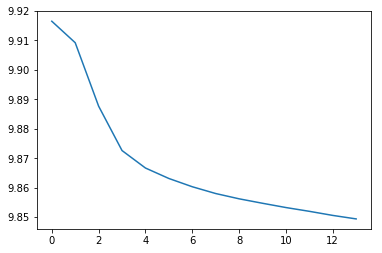

In [139]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.show()

In [141]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.0
Testing F1 score: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [180]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [181]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))


AttributeError: 'list' object has no attribute 'values'